# ResNet50v2 trained on ImageNet-1K

## Install Dependencies

In [1]:
!pip install albumentations --quiet
!pip install torchsummary --quiet
!pip install tqdm --quiet
!pip install matplotlib --quiet
!pip install torch-lr-finder --quiet
!pip install grad-cam --quiet

## Import Modules

In [2]:
# Standard Library Imports
from collections import OrderedDict

# Third Party Imports
import matplotlib.pyplot as plt
import torch
import torchsummary
import torch.nn as nn
import torch.optim as optim
from torch.cuda.amp import autocast, GradScaler
from torch_lr_finder import LRFinder

# Local Imports
from datamodule.dataloader import ImageNetDataLoader
from datamodule.augmentations import ImageNetAugmentations
from model.resnets import ResNet50
from train.training_utils import get_lr, train, test, save_checkpoint
from configs.config import TrainingConfig, ModelConfig, DataConfig
from configs.aws_setup import setup_training_environment
from utils.visualize import display_loss_and_accuracies

/opt/conda/envs/pytorch/lib/python3.11/site-packages/torch_lr_finder/lr_finder.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


## Training Configuration

In [3]:
# Setup training environment and get configuration
config, train_params = setup_training_environment(debug=True)

# Initialize configuration
training_config = TrainingConfig()
model_config = ModelConfig()
data_config = DataConfig()

# Update training parameters based on EC2 optimization
training_config.batch_size = train_params['batch_size']
training_config.num_workers = train_params['num_workers']
training_config.gradient_accumulation_steps = config.gradient_accumulation_steps

# Device configuration
device = 'cuda' if torch.cuda.is_available() else 'cpu'

GPU Information:
{'gpu_count': 1, 'gpu_name': 'Tesla T4', 'cuda_version': '12.4'}

Training Parameters:
{'batch_size': 128, 'effective_batch_size': 512, 'num_workers': 4, 'pin_memory': True, 'prefetch_factor': 2}

Initial GPU Usage:
Sun Dec 29 08:47:40 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.127.05             Driver Version: 550.127.05     CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       On  |   00000000:00:1E.0 Off |                    0 |

## Augmentations

Augmentation to be applied during training on ImageNet-1K training dataset

In [4]:
augmentations = ImageNetAugmentations()

## DataLoaders

In [5]:
# Create training loader
train_loader = ImageNetDataLoader(
    beton_path=data_config.train_path,
    mode='train',
    batch_size=training_config.batch_size,
    num_workers=training_config.num_workers,
    device=device,
    transforms=augmentations.get_transforms('train')
)

# Create validation loader
# test_loader = ImageNetDataLoader(
#     beton_path=data_config.val_path,
#     mode='val',
#     batch_size=training_config.batch_size,
#     num_workers=training_config.num_workers,
#     device=device
# )

## Load Model

In [20]:
# model = ResNet50(num_classes=model_config.num_classes)
# model.to(device)
# torchsummary.summary(model, (3, data_config.input_size, data_config.input_size), device=device)

model = torch.hub.load('pytorch/vision:v0.15.2', 'resnet50', pretrained=True)
model.fc = nn.Linear(model.fc.in_features, model_config.num_classes)
model.to(device)
torchsummary.summary(model, (3, data_config.input_size, data_config.input_size), device=device)


Using cache found in /home/ubuntu/.cache/torch/hub/pytorch_vision_v0.15.2
/opt/conda/envs/pytorch/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/envs/pytorch/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

## Learning Rate Finder

In [21]:
# Loss Function
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = optim.SGD(
    model.parameters(),
    lr=training_config.learning_rate,
    momentum=0.9,
    weight_decay=training_config.weight_decay
)

# GradScaler for mixed precision training
scaler = GradScaler() if training_config.mixed_precision and torch.cuda.is_available() else None

# Compile Model
model = torch.compile(model)

# Learning rate finder
# lr_finder = LRFinder(model, optimizer, criterion, device=device)
# lr_finder.range_test(train_loader, end_lr=10, num_iter=200, step_mode="exp")
# lr_finder.plot()
# lr_finder.reset()

/tmp/ipykernel_12605/456439414.py:13: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler() if training_config.mixed_precision and torch.cuda.is_available() else None


---

## Parameters

In [22]:
MAX_LR = 7.98E-02    # Suggested LR
STEPS_PER_EPOCH = len(train_loader)

## Training Loop

In [23]:
# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []
learning_rates = []
test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}

# Scheduler
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer,
                                                max_lr=MAX_LR,
                                                steps_per_epoch=STEPS_PER_EPOCH,
                                                epochs=training_config.epochs,
                                                pct_start=4/training_config.epochs,
                                                div_factor=100,
                                                three_phase=True,
                                                final_div_factor=100,
                                                anneal_strategy="linear"
                                                )

# For each epoch
for epoch in range(1, training_config.epochs+1):
    print(f'\nEpoch {epoch}')

    # Train the model on training dataset and append the training loss and accuracy
    correct, processed, train_loss = train(model, device, train_loader, optimizer, criterion, scheduler, scaler, training_config.gradient_accumulation_steps)
    train_acc.append(100 * correct / processed)
    train_losses.append(train_loss / len(train_loader))
    learning_rates.append(get_lr(optimizer))

    # Test the model's performance on test dataset and append the training loss and accuracy
    # correct, test_loss = test(model, device, test_loader, criterion)
    # test_acc.append(100. * correct / len(test_loader.dataset))
    # test_losses.append(test_loss)

    # Save the model checkpoint
    save_checkpoint({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_loss': train_loss,
        # 'val_loss': test_loss,
    }, f'checkpoint_epoch_{epoch}.pt')



Epoch 1


Train: Loss=0.5824 Batch_id=467 Accuracy=61.70: 100%|██████████| 468/468 [02:19<00:00,  3.35it/s]



Epoch 2


Train: Loss=0.8863 Batch_id=467 Accuracy=82.96: 100%|██████████| 468/468 [02:19<00:00,  3.35it/s]



Epoch 3


Train: Loss=0.6625 Batch_id=467 Accuracy=81.44: 100%|██████████| 468/468 [02:19<00:00,  3.36it/s]



Epoch 4


Train: Loss=0.9054 Batch_id=467 Accuracy=80.90: 100%|██████████| 468/468 [02:19<00:00,  3.35it/s]



Epoch 5


Train: Loss=0.6650 Batch_id=467 Accuracy=81.19: 100%|██████████| 468/468 [02:19<00:00,  3.36it/s]



Epoch 6


Train: Loss=0.4982 Batch_id=467 Accuracy=83.67: 100%|██████████| 468/468 [02:19<00:00,  3.36it/s]



Epoch 7


Train: Loss=0.6476 Batch_id=467 Accuracy=86.41: 100%|██████████| 468/468 [02:19<00:00,  3.36it/s]



Epoch 8


Train: Loss=0.6902 Batch_id=467 Accuracy=89.22: 100%|██████████| 468/468 [02:19<00:00,  3.35it/s]



Epoch 9


Train: Loss=0.5159 Batch_id=467 Accuracy=90.87: 100%|██████████| 468/468 [02:19<00:00,  3.36it/s]



Epoch 10


Train: Loss=0.4116 Batch_id=467 Accuracy=91.33: 100%|██████████| 468/468 [02:19<00:00,  3.35it/s]


## Visualize Train and Test - Loss and Accuracies

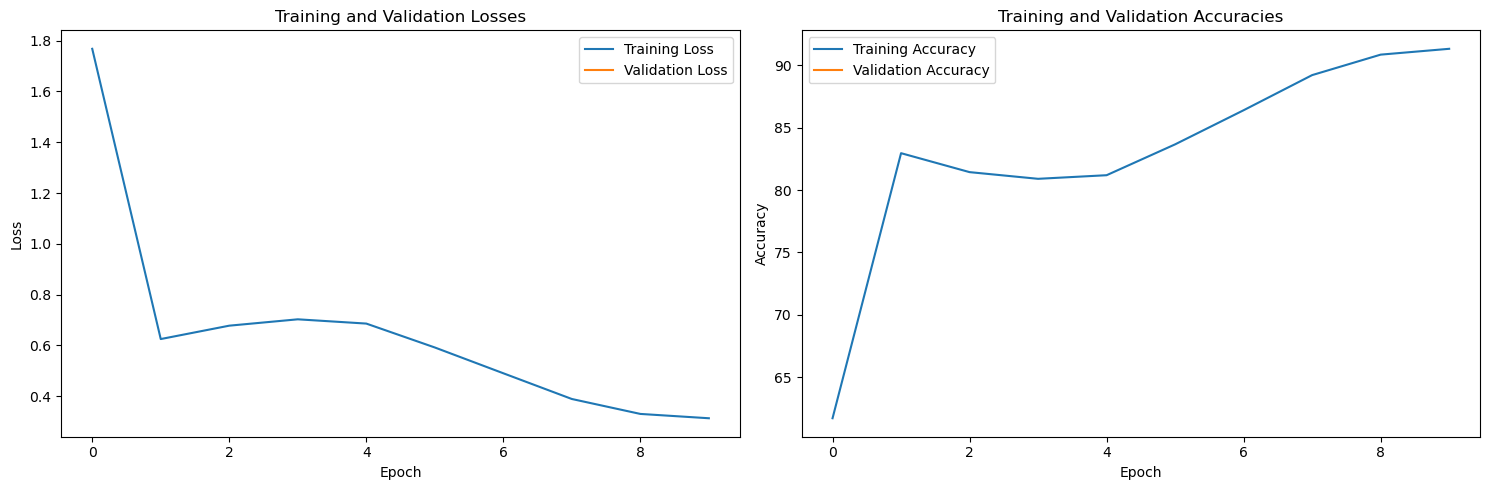

In [24]:
display_loss_and_accuracies(train_losses, train_acc, test_losses, test_acc)

## Visualize One Cycle Policy Implementation

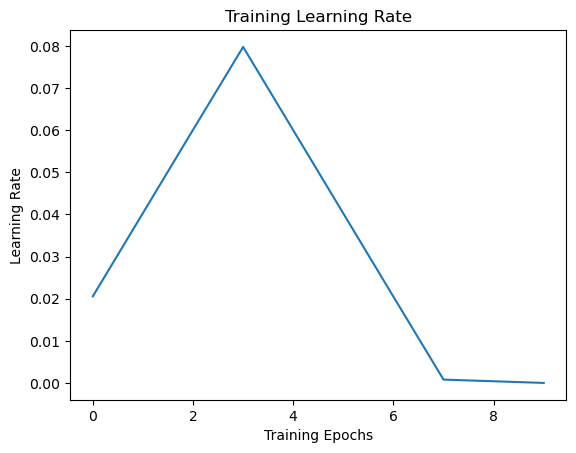

In [25]:
plt.plot(learning_rates)
plt.title("Training Learning Rate")
plt.xlabel("Training Epochs")
plt.ylabel("Learning Rate")
plt.show()

In [26]:
print(f"Training Config: {training_config}")
print(f"Model Config: {model_config}")
print(f"Data Config: {data_config}")


Training Config: TrainingConfig(batch_size=128, epochs=10, learning_rate=0.0554, weight_decay=0.0001, mixed_precision=True, gradient_accumulation_steps=4, num_workers=4)
Model Config: ModelConfig(num_classes=100, dropout_rate=0.1)
Data Config: DataConfig(train_path='train.beton', val_path='val.beton', input_size=224)
